##### Copyright 2023 Melchor Lafuente Duque

# ADJUST THE BPMs

In [1]:
import librosa
import numpy as np
from os.path import join, exists
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
import os

#  Function to transform the signal into mono

In [2]:
def stereo_to_mono(signal):
    if signal.ndim > 1:
        left_channel = signal[:, 0]
        right_channel = signal[:, 1]

        # Calculate the mean of the channels
        signal = np.mean([left_channel, right_channel], axis=0)
        
    return signal

# Read the signals and transform them into mono

In [3]:
# Constants that define the input and the output folders
dirNameInput = 'INPUT'
dirNameOutput = 'OUTPUT_1'

## AUDIO 1: ORIGINAL SIGNAL

**Note:** If when reading the songs it warns us that chunks are missing, it is because the wavs of the songs have been obtained by rendering those songs that were previously mp3. In other words, it's nothing to worry about.

In [4]:
# Read the WAV file 
fileName_origin = 'SY5'
fileSuffix_origin = 'wav'

fileLocation_origin = join(dirNameInput, fileName_origin + "." + fileSuffix_origin)
sample_rate_origin, original_signal = wavfile.read(fileLocation_origin)

# Ensure that the signal is mono
original_signal = stereo_to_mono(original_signal)

/tmp/ipykernel_324891/3052692649.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate_origin, original_signal = wavfile.read(fileLocation_origin)


## AUDIO 2: STYLE SIGNAL

**Note:** Again, if when reading the songs it warns us that chunks are missing, it is because the wavs of the songs have been obtained by rendering those songs that were previously mp3. In other words, it's nothing to worry about.

In [5]:
# Read the WAV file 
fileName_style = 'NCS'
fileSuffix_style = 'wav'

fileLocation_style = join(dirNameInput, fileName_style + "." + fileSuffix_style)
sample_rate_style, style_signal = wavfile.read(fileLocation_style)

# Ensure that the signal is mono
style_signal = stereo_to_mono(style_signal)

/tmp/ipykernel_324891/1858793757.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate_style, style_signal = wavfile.read(fileLocation_style)


# Delete the silences from the audios

We don't want to have silences in our audios, since they don't give us any information. So we create a function to delete the silences at the beginning and end of the signals:

In [6]:
def delete_silence(signal):
    # Delete in the beginning
    i = 0
    while (signal[i] == 0):
        i += 1
        
    # Delete in the end
    j = -1
    while (signal[j] == 0):
        j -= 1
    
    if(j+1 == 0):
        signal = signal[i:]
    else:
        signal = signal[i:j+1]
        
    return signal

In [7]:
original_signal = delete_silence(original_signal)
style_signal = delete_silence(style_signal)

# Original BPMs

Let's analyze their BPMs:

In [8]:
# Compute beat locations for each signal
tempo1, beat_frames1 = librosa.beat.beat_track(y=original_signal.astype('float32'), sr=sample_rate_origin)
tempo2, beat_frames2 = librosa.beat.beat_track(y=style_signal.astype('float32'), sr=sample_rate_style)

print(tempo1, tempo2)

101.33272058823529 123.046875


As we can see their BPMs are very different and we want to have the same one in both. Not only that, but also it's important to line up their beats. In the following plots we can see at what time do each song beat:

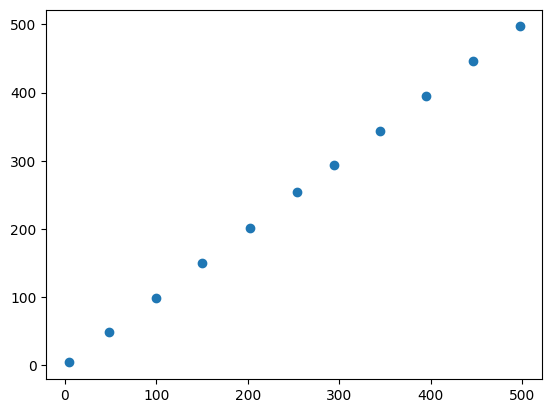

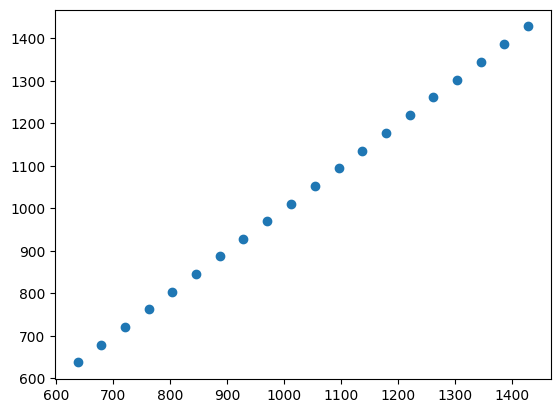

In [9]:
time1 = np.arange(beat_frames1[-1] + 1)
pulse1 = np.zeros(beat_frames1[-1] + 1, dtype=int)

pulse1[beat_frames1] = beat_frames1

plt.scatter(np.where(pulse1 != 0)[0][:11], beat_frames1[:11])
plt.show()

time2 = np.arange(beat_frames2[-1] + 1)
pulse2 = np.zeros(beat_frames2[-1] + 1, dtype=int)

pulse2[beat_frames2] = beat_frames2

plt.scatter(np.where(pulse2 != 0)[0][:20], beat_frames2[:20])
plt.show()

# New BPMs

Let's then calculate the new BPMs and speed up/slow down each song using the following functions:

In [10]:
def new_tempo(tempo_1, tempo_2, aceleration_factor = 1):
    max_tempo = max(tempo_1, tempo_2)
    min_tempo = min(tempo_1, tempo_2)
    desired_tempo = min_tempo + ((max_tempo - min_tempo) * aceleration_factor)
    return desired_tempo

In [11]:
def resample(signal, sr_tempo, tg_tempo, aceleration_factor = 0.5):
    # Compute the desired tempo
    desired_tempo = new_tempo(sr_tempo, tg_tempo, aceleration_factor = aceleration_factor)  # Set the desired tempo in BPM

    # Compute the tempo scaling factor
    tempo_factor = desired_tempo / sr_tempo

    # Resample the audio to the desired tempo
    resample_rate = int(len(signal) / tempo_factor)
    signal_resampled = librosa.resample(signal.astype('float64'), orig_sr = len(signal), target_sr = resample_rate)
    
    return signal_resampled

In [12]:
original_signal_resampled = resample(original_signal, tempo1, tempo2, aceleration_factor = 1)

tempo3, beat_frames3 = librosa.beat.beat_track(y=original_signal_resampled.astype('float64'), sr=sample_rate_origin)
print(tempo3)

style_signal_resampled = resample(style_signal, tempo2, tempo3, aceleration_factor = 1)

tempo4, beat_frames4 = librosa.beat.beat_track(y=style_signal_resampled.astype('float64'), sr=sample_rate_style)
print(tempo4)

123.046875
123.046875


In this moment they follow the same BPM: 123.046875. Let's visualize how much they have been acelerated:

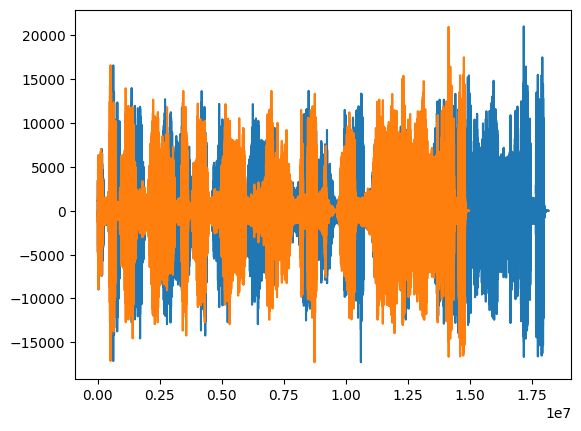

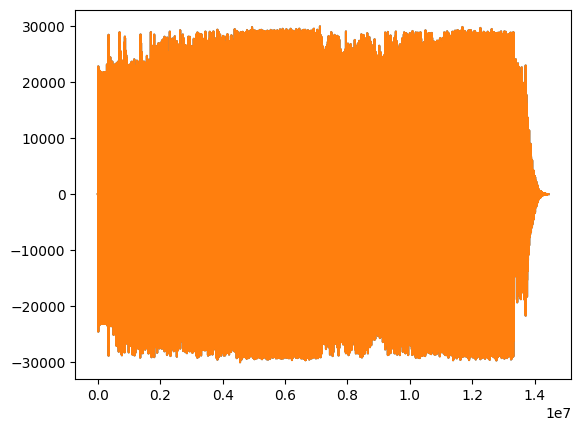

In [13]:
plt.plot(original_signal)
plt.plot(original_signal_resampled)
plt.show()

plt.plot(style_signal)
plt.plot(style_signal_resampled)
plt.show()

And these are their new beats:

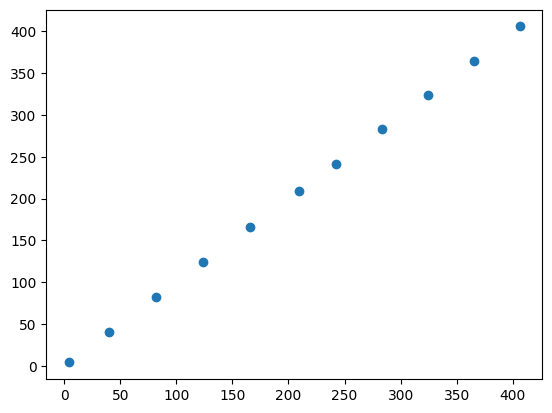

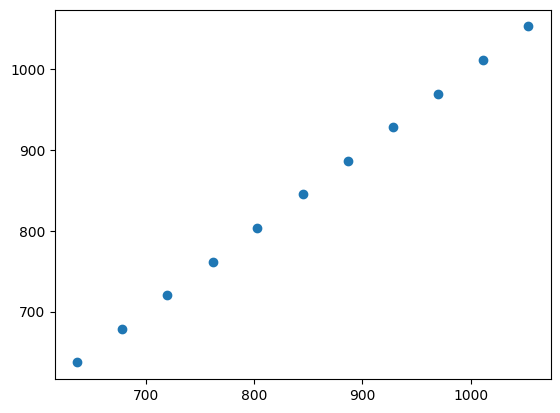

In [14]:
time3 = np.arange(beat_frames3[-1] + 1)
pulse3 = np.zeros(beat_frames3[-1] + 1, dtype=int)

pulse3[beat_frames3] = beat_frames3

plt.scatter(np.where(pulse3 != 0)[0][:11], beat_frames3[:11])
plt.show()

time4 = np.arange(beat_frames4[-1] + 1)
pulse4 = np.zeros(beat_frames4[-1] + 1, dtype=int)

pulse4[beat_frames4] = beat_frames4

plt.scatter(np.where(pulse4 != 0)[0][:11], beat_frames4[:11])
plt.show()

# Line up the songs

Now we are going to line up the songs so that their beats match:

In [15]:
# Calculate the time of each beat in both songs
beat_times3 = librosa.frames_to_time(beat_frames3, sr=sample_rate_origin)
beat_times4 = librosa.frames_to_time(beat_frames4, sr=sample_rate_style)

# Adjust the beat of the first song to match the beats of the second song
time_shift = beat_times4[0] - beat_times3[0] # time between the first beat of each song
samples_shift = int(round(time_shift * sample_rate_origin)) # number of samples to move
if samples_shift > 0:
    original_signal_resampled_aligned = np.concatenate((np.zeros(samples_shift), original_signal_resampled))
else:
    original_signal_resampled_aligned = original_signal_resampled[-samples_shift:]

# Detect the beats of the first adjusted song
tempo3_aligned, beat_frames3_aligned = librosa.beat.beat_track(y=original_signal_resampled_aligned, sr=sample_rate_origin)

# Align the beats of both songs
aligned_beats3 = []
aligned_beats4 = []
for i in range(min(len(beat_frames3_aligned), len(beat_frames4))):
    beat3 = beat_frames3_aligned[i]
    beat4 = beat_frames4[i]
    aligned_beats3.append(beat3)
    aligned_beats4.append(beat4)

# convert beats to time
aligned_beat_times3 = librosa.frames_to_time(aligned_beats3, sr=sample_rate_origin)
aligned_beat_times4 = librosa.frames_to_time(aligned_beats4, sr=sample_rate_style)

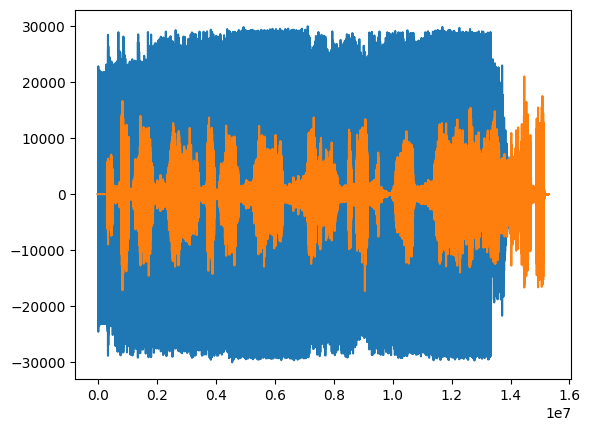

In [16]:
plt.plot(style_signal_resampled)
plt.plot(original_signal_resampled_aligned)
plt.show()

As can be seen in the previous figure, when adjusting the beats to match, we have had to displace one of the songs, creating new silences at the beginning of it. In the next point we will make sure that both songs have the same length. Eliminating from each song the bits at the end and the beginning that escape the intersection of both songs.

# Adjust the songs to have the same duration

In order for both songs to have the same length, as explained in the previous paragraph, we'll keep the parts of each song that intersect and create a fade out at the end of both songs to achieve a smoother result.

In [17]:
def fade_out(signal, fade_out):
    for j in range(-1, -fade_out, -1):    
        if(signal[j] > 0):
            signal[j] -= (((fade_out + j + 1) / fade_out) * abs(signal[j]))
                
        elif(signal[j] < 0):
            signal[j] += (((fade_out + j + 1) / fade_out) * abs(signal[j]))

In [18]:
def cut_signals(original_signal, style_signal, fade_out_duartion = 50):
    
    signal_1 = np.copy(original_signal)
    signal_2 = np.copy(style_signal)
    
    # Delete in the beginning
    i = 0
    while (signal_1[i] == 0):
        i += 1
        
    if signal_1.shape[0] < signal_2.shape[0]:
        signal_1 = signal_1[i:]
        signal_2 = signal_2[i:signal_1.shape[0]]
        
        # Fade Out:
        fade_out(signal_2, fade_out_duartion)
        
    elif signal_1.shape[0] > signal_2.shape[0]:
        signal_1 = signal_1[i:signal_2.shape[0]]
        signal_2 = signal_2[i:]
    
        # Fade Out:
        fade_out(signal_1, fade_out_duartion)
        
        
    return signal_1, signal_2

In [19]:
def write_wav(file_name, sr, signal, output_dir_name = "OUTPUT"):
    current_dir = os.getcwd()
    output_path = os.path.join(current_dir, output_dir_name)
    file_name_output = os.path.join(output_path, file_name + ".wav")
    wavfile.write(file_name_output, sr, signal.astype('int16'))

Finally, this is the result we obtain:

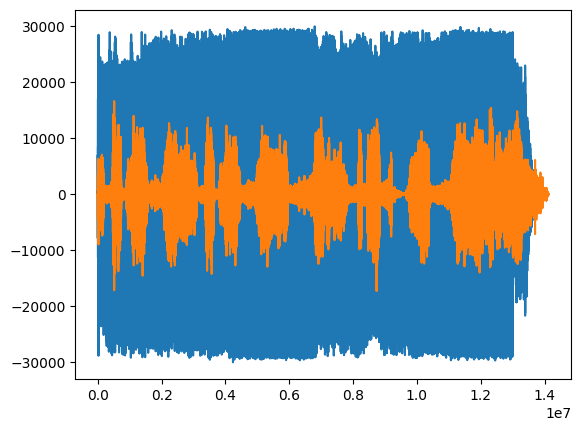

In [20]:
original_signal_resampled_aligned_2, style_signal_resampled_2 = cut_signals(original_signal_resampled_aligned, style_signal_resampled, fade_out_duartion = int(original_signal_resampled_aligned.shape[0]/20))
plt.plot(style_signal_resampled_2)
plt.plot(original_signal_resampled_aligned_2)

write_wav("ORIGINAL_PROCESED", sample_rate_origin, original_signal_resampled_aligned_2.astype('int16'), output_dir_name = "OUTPUT_1")
write_wav("STYLE_PROCESED", sample_rate_style, style_signal_resampled_2.astype('int16'), output_dir_name = "OUTPUT_1")

plt.show()